# Stochastic Runge-Kutta (SRK) demonstration
The `AbstractSRK` class takes a `StochasticButcherTableau` and implements the corresponding SRK method.
Depending on the tableau, the resulting method can either be used for general SDEs, or just for ones with additive noise.
The additive-noise-only methods are somewhat faster, but will fail if the noise is not additive.
Nevertheless, even in the additive noise case, the diffusion vector field can depend on time (just not on the state $y$). Then the SDE has the form:
$$
\mathrm{d}y = f(y, t) \mathrm{d}t + g(t) \mathrm{d}W.
$$
To account for time-dependent noise, the SRK adds a term to the output of each step, which allows it to still maintain its usual strong order of convergence.

The SRK is capable of utilising various types of time Levy area, depending on the tableau provided. It can use:
- just the Brownian motion $W$, withouth any Levy area
- $W$ and the space-time Levy area $H$
- $W$, $H$ and the space-time-time Levy area $K$.
For more information see the documentation of the `StochasticButcherTableau` class.

First we will demonstrate an additive-noise-only SRK method, the ShARK method, on an SDE with additive, time-dependent noise.
For more additive-noise SRKs see the langevin.ipynb notebook.

Then we will demonstrate a general SRK method, Foster's SRK method.

In [1]:
%env JAX_PLATFORM_NAME=cuda

from test.helpers import (
    get_bqp,
    get_harmonic_oscillator,
    get_mlp_sde,
    get_time_sde,
    sde_solver_order,
)

import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, PIDController, SaveAt
from diffrax._solver import ALIGN, Heun, ShARK
from diffrax._solver.foster_srk import FosterSRK
from jax import config


config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=4, suppress=True)


# Plotting
def draw_order(hs, errs):
    plt.plot(1 / hs, errs)
    plt.yscale("log")
    plt.xscale("log")
    pretty_hs = ["{0:0.4f}".format(h) for h in hs]
    plt.xticks(ticks=1 / hs, labels=pretty_hs)
    plt.ylabel("RMS error")
    plt.xlabel("step size")
    plt.show()
    slope, _ = jnp.polyfit(jnp.log(hs), jnp.log(errs), 1)
    print(f"Order of convergence: {slope:.4f}")


def plot_sol_langevin(sol):
    plt.plot(sol.ts, sol.ys[0], label="x")
    plt.plot(sol.ts, sol.ys[1], label="v")
    plt.legend()
    plt.show()


def plot_sol_general(sol):
    plt.plot(sol.ts, sol.ys)
    plt.show()


dtype = jnp.float64
key = jrandom.PRNGKey(2)
num_samples = 100
keys = jrandom.split(jrandom.PRNGKey(5678), num=num_samples)
hs1 = jnp.power(2.0, jnp.arange(-1, -6, -1, dtype=dtype))
hs2 = jnp.power(2.0, jnp.arange(-2, -10, -1, dtype=dtype))


def get_dtype(x):
    if type(x) in [int, float, str]:
        return type(x)
    else:
        return jnp.dtype(x)


t0, t1 = 0.3, 15.0
t_short = 5.1
t_long = 35.0
saveat = SaveAt(ts=jnp.linspace(t0, t1, 1000))
saveat_long = SaveAt(ts=jnp.linspace(t0, t_long, 1000))
dt0 = 0.1

t0_typed, t1_typed = dtype(0.3), dtype(15)
saveat_typed = SaveAt(ts=jnp.linspace(t0, t1, 1000, dtype=dtype))
dt0_typed = dtype(0.1)

hosc = get_harmonic_oscillator(t0, t1, dtype=dtype)
terms_hosc = hosc.get_terms(hosc.get_bm(key, levy_area="space-time", tol=2**-10))
hosc_short = get_harmonic_oscillator(t0, t_short, dtype=dtype)

bqp = get_bqp(t0, t1, dtype=dtype)
terms_bqp = bqp.get_terms(bqp.get_bm(key, levy_area="space-time", tol=2**-10))
bqp_short = get_bqp(t0, t_short, dtype=dtype)

time_sde = get_time_sde(t0, t1, dtype=dtype, noise_dim=3)
terms_time_sde = time_sde.get_terms(
    time_sde.get_bm(key, levy_area="space-time", tol=2**-10)
)
time_sde_short = get_time_sde(t0, t1, dtype=dtype, noise_dim=5)

env: JAX_PLATFORM_NAME=cuda


## Time-dependent noise with the ShARK method

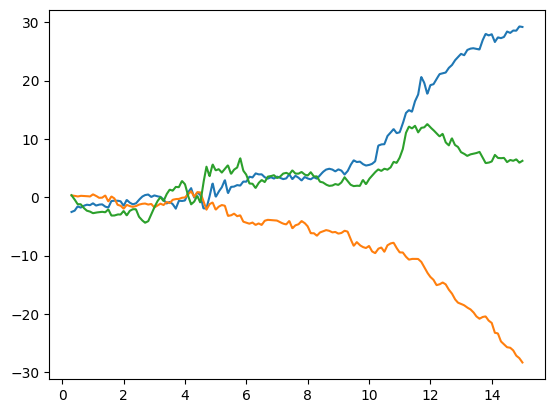

In [2]:
solShARK = diffeqsolve(
    terms_time_sde,
    ShARK(),
    t0,
    t1,
    dt0=dt0,
    y0=time_sde.y0,
    args=time_sde.args,
    saveat=saveat,
)
plot_sol_general(solShARK)

### Compared to a reference solver: Heun

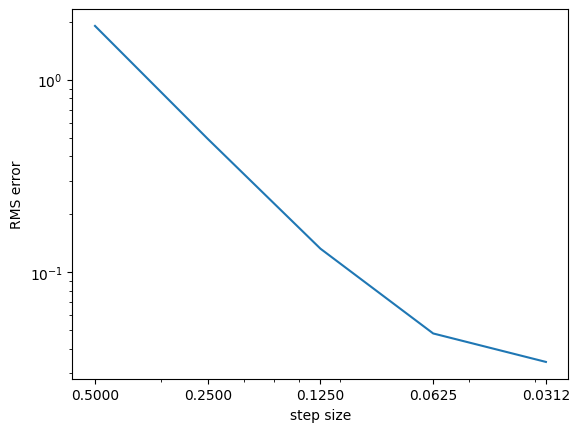

Order of convergence: 1.4941


In [3]:
hs, ShARK_errs_time_sde, _ = sde_solver_order(
    keys, time_sde_short, ShARK(), Heun(), 2**-12, hs=hs1
)
draw_order(hs, ShARK_errs_time_sde)

### Order 2, as expected

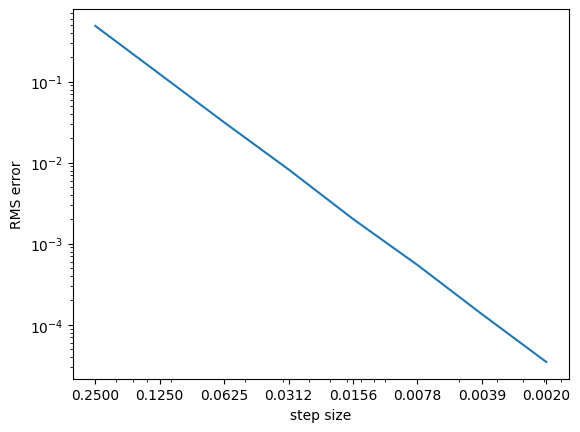

Order of convergence: 1.9661


In [4]:
hs, ShARK_errs_time_sde, _ = sde_solver_order(
    keys, time_sde_short, ShARK(), ShARK(), 2**-11, hs=hs2
)
draw_order(hs, ShARK_errs_time_sde)

 ## Foster's SRK method
This is a general Stochastic Runge-Kutta method with 3 evaluations of the vector field per step,
based on equation 1.6 from
Foster, J. (2023).
On the convergence of adaptive approximations for stochastic differential equations.
arXiv [Math.NA]. Retrieved from http://arxiv.org/abs/2311.14201

For general SDEs, this has order 0.5.
When the noise is commutative it has order 1.
When the noise is additive it has order 1.5.
For the Langevin SDE it has order 2.
Requires the space-time Levy area H.
It also natively supports adaptive time-stepping.

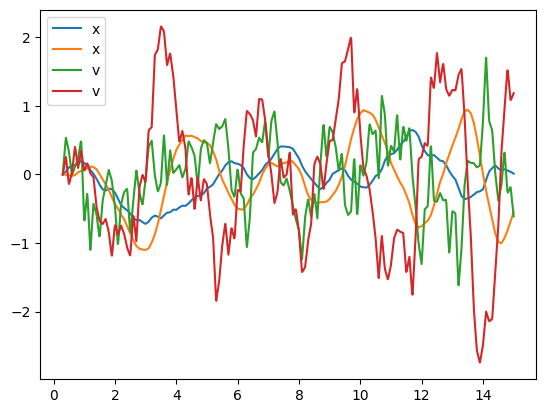

In [2]:
solFosSRK = diffeqsolve(
    terms_hosc, FosterSRK(), t0, t1, dt0=dt0, y0=hosc.y0, args=hosc.args, saveat=saveat
)
plot_sol_langevin(solFosSRK)

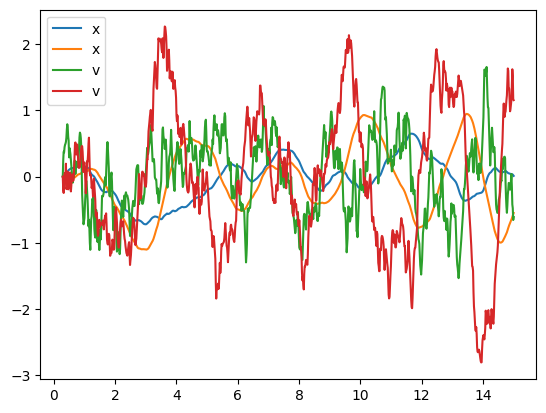

In [3]:
controller = PIDController(pcoeff=0.1, icoeff=0.3, rtol=0.005, atol=0.001)
solFosSRK_PID = diffeqsolve(
    terms_hosc,
    FosterSRK(),
    t0,
    t1,
    dt0=dt0,
    y0=hosc.y0,
    args=hosc.args,
    saveat=saveat,
    stepsize_controller=controller,
)
plot_sol_langevin(solFosSRK_PID)

In [10]:
def sde_strong_order(solver_ctr, commutative=False):
    key = jrandom.PRNGKey(5678)
    sde_key, bmkey = jrandom.split(key, 4)
    num_samples = 10
    bmkeys = jrandom.split(bmkey, num=num_samples)

    if commutative:
        noise_dim = 1
    else:
        noise_dim = 5

    t0 = 0
    t1 = 2
    sde = get_mlp_sde(t0, t1, dtype=dtype, key=sde_key, noise_dim=noise_dim)

    # Reference solver is always an ODE-viable solver, so its implementation has been
    # verified by the ODE tests like test_ode_order.
    hs = jnp.power(2.0, jnp.arange(-3, -10, -1, dtype=dtype))
    hs, errors, order = sde_solver_order(
        bmkeys, sde, solver_ctr(), solver_ctr(), 2**-12, hs=hs
    )
    draw_order(hs, errors)
    return hs, errors, order

### Order 0.5 for general SDEs

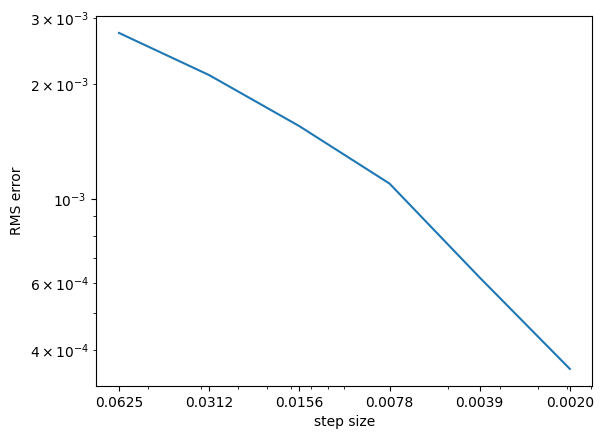

Order of convergence: 0.5858


In [11]:
out = sde_strong_order(FosterSRK, commutative=False)

### Order 1 when noise is commutative

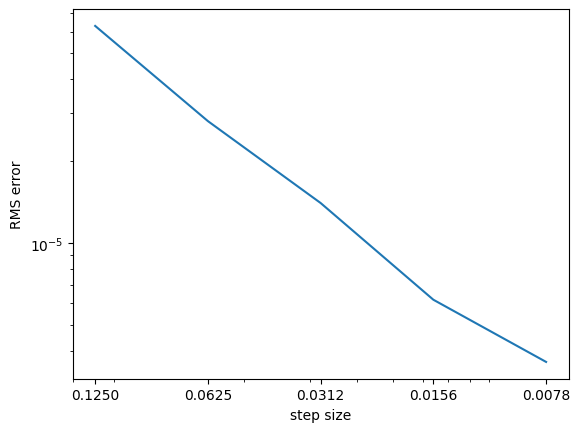

Order of convergence: 1.0409


In [6]:
out_commutative = sde_strong_order(FosterSRK, commutative=True)

### Order 2 for the Langevin SDE

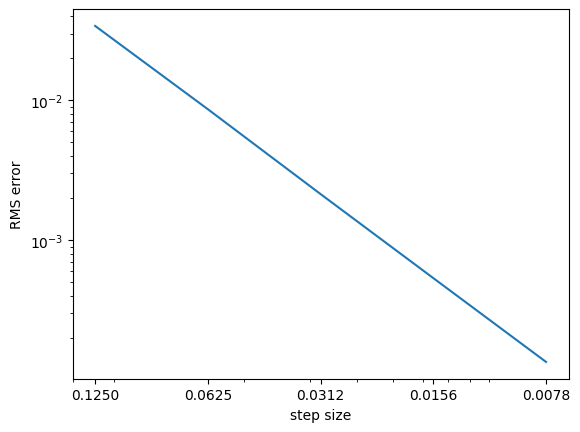

Order of convergence: 1.9994


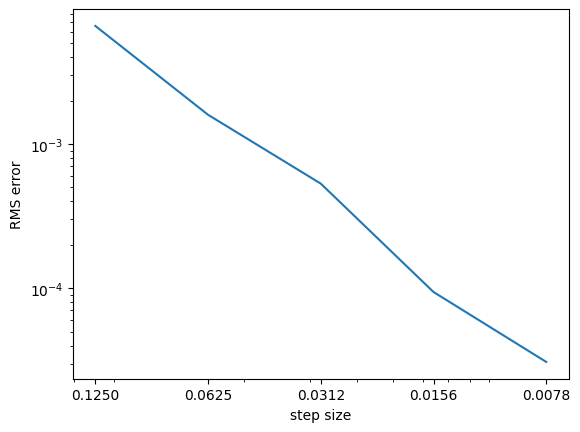

Order of convergence: 1.9577


In [7]:
hs, FosSRK_errs_hosc, _ = sde_solver_order(
    keys, hosc, FosterSRK(), ALIGN(0.1), 2**-12, hs=hs1
)
draw_order(hs, FosSRK_errs_hosc)
hs, FosSRK_errs_bqp, _ = sde_solver_order(
    keys, bqp, FosterSRK(), ALIGN(0.1), 2**-12, hs=hs1
)
draw_order(hs, FosSRK_errs_bqp)